In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import acnportal
import sklearn
from matplotlib import pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns

from copy import deepcopy
import warnings
import pytz
import time
import numpy as np
import pandas as pd
import pickle
from datetime import datetime, timedelta
from enum import Enum
from collections import namedtuple, defaultdict
import gzip
import random
import os
import json

from acnportal import acnsim
from acnportal import algorithms
from acnportal.acnsim.events import EventQueue
# from acnportal.signals.tariffs.tou_tariff import TimeOfUseTariff
from utility_functions.signals.tariffs.tou_tariff import TimeOfUseTariff
from acnportal.acnsim.events import GaussianMixtureEvents
from acnportal.contrib.acnsim import StochasticNetwork
from acnportal.acnsim.network import ChargingNetwork
from modified_adacharge import modified_adacharge
from modified_simulator import modified_simulator
# from acnportal.acnsim import analysis
from utility_functions import analysis
# from modified_evse import *
from acnportal.acnsim.models.evse import get_evse_by_type
# import sqlite3
# from sqlalchemy import create_engine

In [3]:
# This method won't take a evse_per_phase argument
def ev_fleet_level_2_network(transformer_cap=30):
    """ Configurable charging network for level-2 EVSEs connected line to line
        at 415 V.

    Args:
        transformer_cap (float): Capacity of the transformer feeding the network
          [kW]
        evse_per_phase (int): Number of EVSEs on each phase. Total number of
          EVSEs will be 3 * evse_per_phase.

    Returns:
        ChargingNetwork: Configured ChargingNetwork.
    """
    network = StochasticNetwork(early_departure=True)
    # network = ChargingNetwork()
    voltage = 415
    evse_type = 'AeroVironment'
    # evse_type = 'ClipperCreek'

    # Define the sets of EVSEs in the Caltech ACN.
    AB_ids = ['AB-{0}'.format(i) for i in range(4)]
    BC_ids = ['BC-{0}'.format(i) for i in range(4)]
    CA_ids = ['CA-{0}'.format(i) for i in range(4)]

    # print(AB_ids)

    # Add Caltech EVSEs
    for evse_id in AB_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 30)
    for evse_id in BC_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, -90)
    for evse_id in CA_ids:
        network.register_evse(get_evse_by_type(evse_id, evse_type), voltage, 150)

    # Add Caltech Constraint Set
    AB = acnsim.Current(AB_ids)
    BC = acnsim.Current(BC_ids)
    CA = acnsim.Current(CA_ids)

    # Define intermediate currents
    I3a = AB - CA
    I3b = BC - AB
    I3c = CA - BC
    I2a = (1 / 4) * (I3a - I3c)
    I2b = (1 / 4) * (I3b - I3a)
    I2c = (1 / 4) * (I3c - I3b)

    # Build constraint set
    primary_side_constr = transformer_cap * 1000 / 3 / 415
    print(primary_side_constr)
    secondary_side_constr = transformer_cap * 1000 / 3 / 230
    print(secondary_side_constr)
    network.add_constraint(I3a, secondary_side_constr, name='Secondary A')
    network.add_constraint(I3b, secondary_side_constr, name='Secondary B')
    network.add_constraint(I3c, secondary_side_constr, name='Secondary C')
    network.add_constraint(I2a, primary_side_constr, name='Primary A')
    network.add_constraint(I2b, primary_side_constr, name='Primary B')
    network.add_constraint(I2c, primary_side_constr, name='Primary C')

    return network

In [4]:
# How long each time discrete time interval in the simulation should be.
PERIOD = 5  # minutes

# Voltage of the network.
VOLTAGE = 415  # volts      

# Default maximum charging rate for each EV battery.
DEFAULT_BATTERY_POWER = 11 # kW

#### Generate synthetic events for simulation

In [5]:
# Generate synthetic events based on JPL data provided by ACN-Sim.
class CustomUnpicklerJPLdata(pickle.Unpickler):
    def find_class(self, module, name):
        if name == "sklearn.mixture.gaussian_mixture":
            return sklearn.mixture.GaussianMixture
        if name == "GaussianMixture":
            return sklearn.mixture.GaussianMixture
        return super().find_class(module, name)
    
def get_synth_events(sessions_per_day):
    gmm = CustomUnpicklerJPLdata(open('./data/jpl_weekday_40.pkl', "rb")).load()


    # Generate a list of the number of sessions to draw for each day.
    # This generates 30 days of charging demands.
    # num_evs = [0]*2 + [sessions_per_day]*5 + [0]*2 + [sessions_per_day]*5 + [0]*2 + \
    #           [sessions_per_day]*5 + [0]*2 + [sessions_per_day]*5 + [0]*2

    # Generate sessions for 1 day (weekdays only)
    num_evs = [0]*2 + [sessions_per_day]*1

    # Note that because we are drawing from a distribution, some sessions will be
    # invalid, we ignore these sessions and remove the corresponding plugin events.
    # gen = GaussianMixtureEvents(pretrained_model=gmm, duration_min=0.08334)
    gen = GaussianMixtureEvents(pretrained_model=gmm, duration_min=5)

    synth_events = gen.generate_events(num_evs, PERIOD, VOLTAGE, DEFAULT_BATTERY_POWER)
    return synth_events

In [6]:
# 36 EV sessions per weekday
events_36_ev = get_synth_events(36)

c:\Users\s3955218\Anaconda3\envs\evsim\lib\site-packages\sklearn\base.py:288: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
# Checking session details
session_copy = deepcopy(events_36_ev)
# print(type(session_copy))
session_list = list(session_copy.queue)
for session in session_list:
    print(session[0], session[1].ev._session_id, session[1].ev.arrival, \
          session[1].ev.departure, session[1].ev.requested_energy, session[1].event_type)

627 session_35 627 736 17.42132375716581 Plugin
639 session_24 639 753 7.775474460095065 Plugin
648 session_12 648 752 12.981633112707092 Plugin
654 session_9 654 763 41.98713814970059 Plugin
659 session_22 659 732 2.7307665940950927 Plugin
650 session_5 650 761 12.474509486420247 Plugin
655 session_14 655 790 27.248363400712513 Plugin
659 session_33 659 778 17.20235134447305 Plugin
657 session_15 657 765 20.773945962001157 Plugin
670 session_0 670 774 0.7981425460560974 Plugin
666 session_3 666 734 11.104021319097722 Plugin
660 session_4 660 770 11.961121582682832 Plugin
661 session_25 661 779 11.593278932872762 Plugin
671 session_6 671 790 12.036328874182326 Plugin
658 session_13 658 803 18.581010645144268 Plugin
664 session_31 664 776 13.010309037982491 Plugin
660 session_32 660 785 12.563641114382639 Plugin
732 session_8 732 792 22.957334308124075 Plugin
754 session_18 754 814 8.492583519796778 Plugin
754 session_19 754 814 4.782009258841906 Plugin
765 session_20 765 825 7.78382155

#### Algorithms and new equation

In [9]:
sch = {}
sch['Unctrl'] = algorithms.UncontrolledCharging()
sch['RR'] = algorithms.RoundRobin(algorithms.first_come_first_served, continuous_inc=1)

cost_min_obj = [
                modified_adacharge.ObjectiveComponent(modified_adacharge.tou_energy_cost_with_pv),
                modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_without_priority_ev),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_for_priority_ev),
                modified_adacharge.ObjectiveComponent(modified_adacharge.quick_charge, 1e-6)
               ]

sch['MPC'] = modified_adacharge.AdaptiveSchedulingAlgorithm(cost_min_obj, solver="MOSEK", quantize=True, reallocate=False, peak_limit=300, max_recompute=1)

#### Run Simulation with New Equation

In [10]:
sims = dict()
def run_experiment(alg_name, cap):
    """ Run simulation for the events defined previously and the specified
        network / algorithm / events.
    """
    # Timezone of the ACN we are using.
    # timezone = pytz.timezone('America/Los_Angeles')
    # Australian timezone for the experiment
    timezone = pytz.timezone('Australia/Melbourne')

    start = timezone.localize(datetime(2025, 5, 8))
    end = timezone.localize(datetime(2025, 5, 8))

    cn = ev_fleet_level_2_network(transformer_cap=cap)

    alg = deepcopy(sch[alg_name])
    alg.max_rate_estimator = algorithms.SimpleRampdown()
    alg.estimate_max_rate = True
    experiment_events = deepcopy(events_36_ev)
    signals = {'tariff': TimeOfUseTariff('sce_tou_ev_4_march_2019')}

    sim = modified_simulator.Simulator(cn, alg, experiment_events, start, period=PERIOD, signals=signals, verbose=False)
    print("Running...")
    start_simulation = time.time()
    if alg_name == "MPC_Offline":
        alg.register_events(experiment_events)
        alg.solve()
    # if alg_name == "MPC":
    #     sim.high_priority_ev_sessions = ["session_19", "session_7", "session_15", "session_10"]
    # sim.high_priority_ev_sessions = ["session_4", "session_12", "session_2"]
    sim.run()
    print(f"Run time: {time.time() - start_simulation}")

    return sim

In [11]:
warnings.simplefilter("ignore")

capacities = list(range(90, 130, 5))
alg_names = ["Unctrl", "RR", "MPC"]

for cap in capacities:
    for alg_name in alg_names:
        config = (alg_name, cap)
        print(config)
        if config not in sims:
            try:
                sims[config] = run_experiment(*config)
            except Exception as e:
                print(f"InfeasibilityException: {e}")
                sims[config] = None
                continue

('Unctrl', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 0.4751091003417969
('RR', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 2.1591413021087646
('MPC', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 16.50617289543152
('Unctrl', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 0.39993834495544434
('RR', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 2.000246286392212
('MPC', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 16.450801372528076
('Unctrl', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 0.3974645137786865
('RR', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 1.9934728145599365
('MPC', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 16.32434105873108
('Unctrl', 105)
84.33734939759036
152.17391304347825
Running...
Run time: 0.38321638107299805
('RR', 105)
84.33734939759036
152.17391304347825
Running...
Run time: 2.00780987739563
('MPC', 105

In [6]:
# result_dir = "results/sims/new_simulation"
# if not os.path.exists(result_dir):
#     os.makedirs(result_dir)
    
# for config, sim in sims.items():
#     name = "results/sims/new_simulation/{0}-{1}.json.gz".format(*config)
#     if not os.path.exists(name):
#         data = sim.to_json()
#         with gzip.GzipFile(name, 'w') as fout:
#             fout.write(json.dumps(data).encode('utf-8'))

#### Result Analysis

In [12]:
def calc_metrics(config, sim):
    metrics = {
        "Network Type": "three_phase",
        "Algorithm": config[0],
        "Capacity (kW)": config[1],
        "Energy Delivered (%)": analysis.proportion_of_energy_delivered(sim) * 100,
        "Demand met": analysis.proportion_of_demands_met(sim) * 100,
        "Max Utilization (%)": np.max(analysis.aggregate_power(sim)) / config[1] * 100,
        "energy_cost": analysis.energy_cost(sim),
        "total_energy_delivered": analysis.total_energy_delivered(sim),
        "Energy Delivered to priority evs (%)": analysis.proportion_of_priority_evs_energy_delivered(sim, ["session_35",
                                                                                                           "session_12",
                                                                                                           "session_5",
                                                                                                           "session_33",
                                                                                                           "session_14",
                                                                                                           "session_13",
                                                                                                            "session_28",
                                                                                                           "session_17",
                                                                                                           "session_15",
                                                                                                           ]),
        "Peak (kW)": np.max(analysis.aggregate_power(sim))
    }
    metrics["Current Unbalance"] = np.nanmean(analysis.current_unbalance(sim, ['Secondary {0}'.format(p) for p in 'ABC'], 'NEMA'))

    return metrics

In [13]:
# filter the sims dict to only include the ones that are not None
sims = {k: v for k, v in sims.items() if v is not None}

In [14]:
metrics = pd.DataFrame(calc_metrics(config, sim) for config, sim in sims.items()).round(3)
metrics.rename(columns={"Capacity (kW)": "capacity"}, inplace=True)

In [15]:
metrics

,Network Type,Algorithm,capacity,Energy Delivered (%),Demand met,Max Utilization (%),energy_cost,total_energy_delivered,Energy Delivered to priority evs (%),Peak (kW),Current Unbalance
0,three_phase,Unctrl,90,100.000,100.000,146.667,28.456,467.490,100.000,132.000,0.401
1,three_phase,RR,90,79.833,77.778,98.678,22.717,373.210,99.768,88.810,0.375
2,three_phase,MPC,90,81.714,36.111,92.694,23.253,382.007,100.000,83.425,0.391
3,three_phase,Unctrl,95,100.000,100.000,138.947,28.456,467.490,100.000,132.000,0.397
4,three_phase,RR,95,79.897,77.778,92.179,22.736,373.511,99.886,87.570,0.403
5,three_phase,MPC,95,82.374,36.111,91.305,23.440,385.091,100.000,86.740,0.369
6,three_phase,Unctrl,100,100.000,100.000,132.000,28.456,467.490,100.000,132.000,0.390
7,three_phase,RR,100,79.882,77.778,91.305,22.731,373.440,99.843,91.305,0.374
8,three_phase,MPC,100,82.808,36.111,82.600,23.564,387.119,100.000,82.600,0.375
9,three_phase,Unctrl,105,100.000,100.000,125.714,28.456,467.490,100.000,132.000,0.381


#### Simulation with different algorithms

In [16]:
sch = {}
sch['Unctrl'] = algorithms.UncontrolledCharging()
sch['LLF'] = algorithms.SortedSchedulingAlgo(algorithms.least_laxity_first)

cost_min_obj = [
                modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty),
                modified_adacharge.ObjectiveComponent(modified_adacharge.tou_energy_cost_with_pv),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_for_priority_ev, 2),
                # modified_adacharge.ObjectiveComponent(modified_adacharge.non_completion_penalty_without_priority_ev),
                modified_adacharge.ObjectiveComponent(modified_adacharge.quick_charge, 1e-6)
               ]

sch['MPC'] = modified_adacharge.AdaptiveSchedulingAlgorithm(cost_min_obj, solver="MOSEK", quantize=True, reallocate=False, peak_limit=200, max_recompute=1)

In [17]:
sims = dict()

In [18]:
warnings.simplefilter("ignore")

capacities = list(range(90, 130, 5))
alg_names = ["Unctrl", "LLF", "MPC"]

for cap in capacities:
    for alg_name in alg_names:
        config = (alg_name, cap)
        print(config)
        if config not in sims:
            sims[config] = run_experiment(*config)

('Unctrl', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 0.4433155059814453
('LLF', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 0.9756217002868652
('MPC', 90)
72.28915662650603
130.43478260869566
Running...
Run time: 18.184284925460815
('Unctrl', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 0.4815835952758789
('LLF', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 1.0884990692138672
('MPC', 95)
76.30522088353413
137.68115942028987
Running...
Run time: 17.43470287322998
('Unctrl', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 0.41361403465270996
('LLF', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 0.965054988861084
('MPC', 100)
80.32128514056225
144.92753623188406
Running...
Run time: 17.8670494556427
('Unctrl', 105)
84.33734939759036
152.17391304347825
Running...
Run time: 0.41808199882507324
('LLF', 105)
84.33734939759036
152.17391304347825
Running...
Run time: 0.9165363311767578
('MPC'

In [19]:
# filter the sims dict to only include the ones that are not None
sims = {k: v for k, v in sims.items() if v is not None}

In [20]:
metrics = pd.DataFrame(calc_metrics(config, sim) for config, sim in sims.items()).round(3)
metrics.rename(columns={"Capacity (kW)": "capacity"}, inplace=True)

In [21]:
metrics

,Network Type,Algorithm,capacity,Energy Delivered (%),Demand met,Max Utilization (%),energy_cost,total_energy_delivered,Energy Delivered to priority evs (%),Peak (kW),Current Unbalance
0,three_phase,Unctrl,90,100.000,100.000,146.667,28.456,467.490,100.000,132.000,0.392
1,three_phase,LLF,90,79.860,77.778,83.478,22.725,373.336,99.806,75.130,0.363
2,three_phase,MPC,90,81.399,38.889,88.767,23.163,380.534,100.000,79.890,0.387
3,three_phase,Unctrl,95,100.000,100.000,138.947,28.456,467.490,100.000,132.000,0.384
4,three_phase,LLF,95,79.860,77.778,83.453,22.725,373.340,99.808,79.280,0.355
5,three_phase,MPC,95,82.733,36.111,85.189,23.543,386.767,100.000,80.930,0.350
6,three_phase,Unctrl,100,100.000,100.000,132.000,28.456,467.490,100.000,132.000,0.383
7,three_phase,LLF,100,79.805,77.778,89.655,22.709,373.080,99.710,89.655,0.385
8,three_phase,MPC,100,82.774,36.111,81.550,23.554,386.960,100.000,81.550,0.376
9,three_phase,Unctrl,105,100.000,100.000,125.714,28.456,467.490,100.000,132.000,0.396


In [22]:
for config, sim in sims.items():
    print(config, sim)

('Unctrl', 90) modified_simulator.modified_simulator.Simulator(network=<acnportal.contrib.acnsim.network.stochastic_network.StochasticNetwork object at 0x000002EE48693FA0>, scheduler=<acnportal.algorithms.uncontrolled_charging.UncontrolledCharging object at 0x000002EE426D29A0>, max_recompute=1, event_queue=<acnportal.acnsim.events.event_queue.EventQueue object at 0x000002EE486232B0>, start=<datetime.datetime object at 0x000002EE4864CC30>, period=5, signals=<dict object at 0x000002EE42A202C0>, verbose=False, pilot_signals=<numpy.ndarray object at 0x000002EE4294FE10>, charging_rates=<numpy.ndarray object at 0x000002EE4294F7B0>, peak=<numpy.float64 object at 0x000002EE428451B0>, ev_history=<dict object at 0x000002EE42A20700>, event_history=<list object at 0x000002EE486B3C00>, high_priority_ev_sessions=<list object at 0x000002EE486B37C0>, schedule_history=None, _iteration=877, _resolve=False, _last_schedule_update=876)
('LLF', 90) modified_simulator.modified_simulator.Simulator(network=<ac

In [33]:
def plot_ev_charging(sim, ev, ax, label, label_auto_place=False):
    evse_index = sim.network.station_ids.index(ev.station_id)
    session_len = ev.departure - ev.arrival
    x = [sim.start + timedelta(minutes=5 * ev.arrival) + timedelta(minutes=5*i) for i in range(session_len)]
    ax.step(x, sim.charging_rates[evse_index][ev.arrival:ev.departure],
            label=label, linewidth=2)
    if label_auto_place:
        ax.legend()
    else:
        ax.text(0.02, 0.9, label, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes)

def plot_profiles(sims, cap, ev, end=None, label_auto_place=False):
    fig, axes = plt.subplots(4, 1, sharey=True, sharex=True, figsize=(7, 6))

    x_min = sim.start + timedelta(minutes=5 * ev.arrival)
    x_max = end if end is not None else sim.start + timedelta(minutes=5 * ev.departure)
    axes[0].set_xlim(x_min, x_max)
    axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.autofmt_xdate()

    axes[0].set_ylim(0, 35)
    axes[0].set_yticks([0, 15, 35])
    
    plt.subplots_adjust(hspace=.2)
    fig.text(0.035, 0.55, 'Charging Current (A)', va='center', rotation='vertical')
    print(ev.session_id)
    for i, alg_name in enumerate(["Unctrl", "LLF", "MPC"]):
        # label = alg_name if alg_name != "Offline" else "Offline Optimal"
        label = alg_name
        plot_ev_charging(sims[alg_name, cap], ev, axes[i], label=label, label_auto_place=label_auto_place)
        axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)
    return fig

In [34]:
evs = list(sims["LLF", cap].ev_history.values())
print(evs)

[acnportal.acnsim.models.ev.EV(_arrival=627, _departure=736, _session_id=<str object at 0x000002EE422A5C30>, _station_id=<str object at 0x000002EE42A8EF70>, _requested_energy=<numpy.float64 object at 0x000002EE42628CD0>, _estimated_departure=736, _battery=<acnportal.acnsim.models.battery.Battery object at 0x000002EE424A7BB0>, _energy_delivered=<numpy.float64 object at 0x000002EE429D3870>, _current_charging_rate=<numpy.float64 object at 0x000002EE42784350>), acnportal.acnsim.models.ev.EV(_arrival=639, _departure=753, _session_id=<str object at 0x000002EE42295F70>, _station_id=<str object at 0x000002EE42A8E1B0>, _requested_energy=<numpy.float64 object at 0x000002EE42628030>, _estimated_departure=753, _battery=<acnportal.acnsim.models.battery.Battery object at 0x000002EE424A7970>, _energy_delivered=<numpy.float64 object at 0x000002EE424C9FD0>, _current_charging_rate=<numpy.float64 object at 0x000002EE424C9610>), acnportal.acnsim.models.ev.EV(_arrival=648, _departure=752, _session_id=<str 

session_28


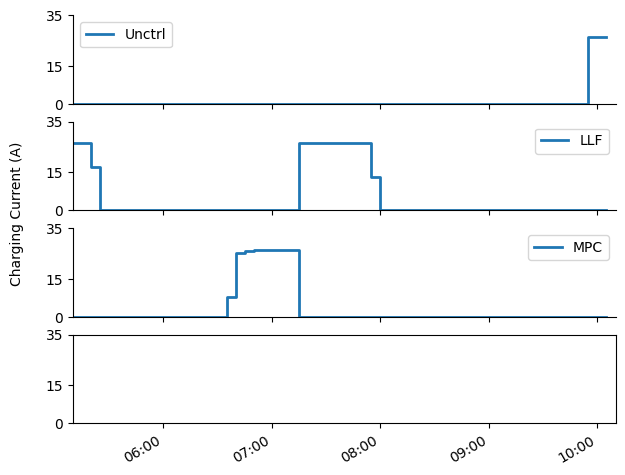

In [40]:
ev = random.choice(list(sims["LLF", cap].ev_history.values()))
cap = 100
plot_profiles(sims, cap, ev, label_auto_place=True)
plt.show()